In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np

%matplotlib inline

In [ ]:
def plot(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(0.2859, 0.3530)])

trainset = datasets.FashionMNIST('./data', download=True, train=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('./data', download=True, train=False, transform=transform)
test_loader = DataLoader(testset, batch_size=64, shuffle=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 11295164.24it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 207308.83it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3783631.97it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15982440.41it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



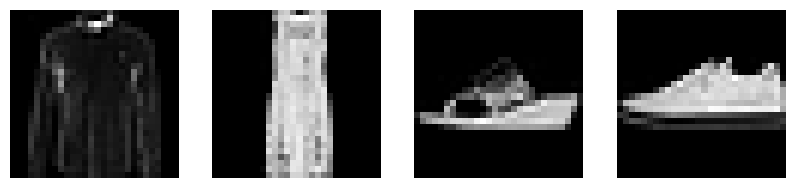

In [ ]:
for _, data in enumerate(train_loader):
    fig, ax = plt.subplots(1, 4, figsize=(10, 4))

    for i in range(4):
        ax[i].imshow(data[0][i].squeeze(), cmap="gray")
        ax[i].axis("off")
    plt.show()
    break

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_sizes, activation_fnc=nn.Tanh()):
        super(Encoder, self).__init__()
        assert len(latent_sizes) > 0
        n_layers = len(latent_sizes)
        input_sizes = [28*28] + latent_sizes[:-1]
        output_sizes = latent_sizes
        self.model = nn.Sequential()
        layers = []
        for i in range(n_layers-1):
            layers.append(nn.Linear(input_sizes[i], output_sizes[i]))
            layers.append(activation_fnc)
        layers.append(nn.Linear(input_sizes[-1], output_sizes[-1]))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = torch.sigmoid(self.model(x))
        return x

class Decoder(nn.Module):
    def __init__(self, latent_sizes, activation_fnc=nn.Tanh()):
        super(Decoder, self).__init__()
        assert len(latent_sizes) > 0
        n_layers = len(latent_sizes)
        input_sizes = latent_sizes[::-1]
        output_sizes = latent_sizes[:-1][::-1] + [28*28]
        self.model = nn.Sequential()
        layers = []
        for i in range(n_layers-1):
            layers.append(nn.Linear(input_sizes[i], output_sizes[i]))
            layers.append(activation_fnc)
        layers.append(nn.Linear(input_sizes[-1], output_sizes[-1]))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = torch.tanh(self.model(x))
        return x

In [ ]:
class Net(nn.Module):
    def __init__(self, latent_sizes=None, loss_fn=F.mse_loss, lr=1e-4, l2=0., activation_fnc=nn.Tanh()):
        super(Net, self).__init__()
        if latent_sizes is None:
            latent_sizes = [10, 2]
        self.E = Encoder(latent_sizes, activation_fnc=activation_fnc)
        self.D = Decoder(latent_sizes, activation_fnc=activation_fnc)
        self.loss_fn = loss_fn
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)

    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        out = self.D(h)
        return out

    def encode(self, x):
        with torch.no_grad():
            x = x.view(-1, 28*28)
            return self.E(x)

    def decode(self, h):
        with torch.no_grad():
            return self.D(h)

    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()

        if batch_idx % 150 == 0:
            line = 'Train Epoch: {} [{:05d}/{}] '.format(
                epoch, batch_idx * len(data), train_size)
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)

    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{:05d}/{}] '.format(
            epoch, batch_idx * len(data), train_size)
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append(models[k]._loss)
        print(line + losses)

avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
line = lambda i, l: '{}: '.format(i) + avg_lambda(l)

def test(models, loader, log=None):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item()

    for k in models:
        test_loss[k] /= (test_size * 784)
        if log is not None:
            log[k].append(test_loss[k])

    lines = '\n'.join([line(k, test_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    print(report)

In [ ]:
models = {
    'model1': Net(latent_sizes=[32, 2]),
    'model2': Net(latent_sizes=[32, 16, 2]),
}
for model_name in models:
    models[model_name].to(device)
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}
device

device(type='cpu')

In [ ]:
for epoch in range(1, 10):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, test_loader, test_log)

Train Epoch: 1 [00000/60000] model1: 1.057081 model2: 1.026724
Train Epoch: 1 [09600/60000] model1: 0.930772 model2: 0.942182
Train Epoch: 1 [19200/60000] model1: 0.802194 model2: 0.785047
Train Epoch: 1 [28800/60000] model1: 0.689202 model2: 0.671619
Train Epoch: 1 [38400/60000] model1: 0.630866 model2: 0.630520
Train Epoch: 1 [48000/60000] model1: 0.595088 model2: 0.598625
Train Epoch: 1 [57600/60000] model1: 0.631380 model2: 0.637321
Train Epoch: 1 [30016/60000] model1: 0.528825 model2: 0.530508
Test set:
model1: loss: 0.5747
model2: loss: 0.5755

Train Epoch: 2 [00000/60000] model1: 0.595786 model2: 0.594573
Train Epoch: 2 [09600/60000] model1: 0.571107 model2: 0.563361
Train Epoch: 2 [19200/60000] model1: 0.526987 model2: 0.514584
Train Epoch: 2 [28800/60000] model1: 0.577788 model2: 0.568211
Train Epoch: 2 [38400/60000] model1: 0.499698 model2: 0.498408
Train Epoch: 2 [48000/60000] model1: 0.536324 model2: 0.532454
Train Epoch: 2 [57600/60000] model1: 0.535962 model2: 0.538066
Tr

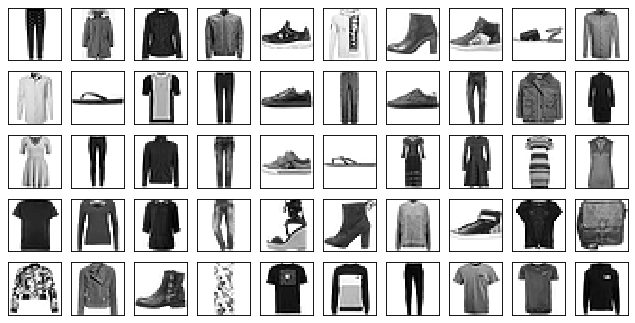

model1


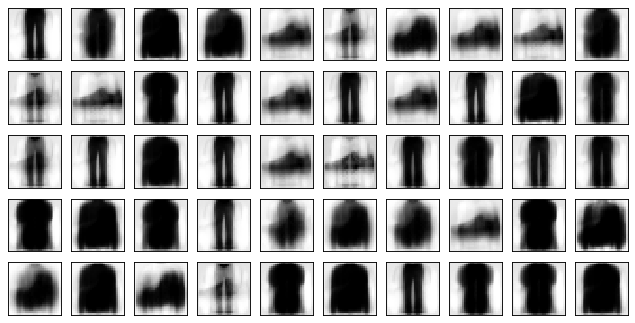

model2


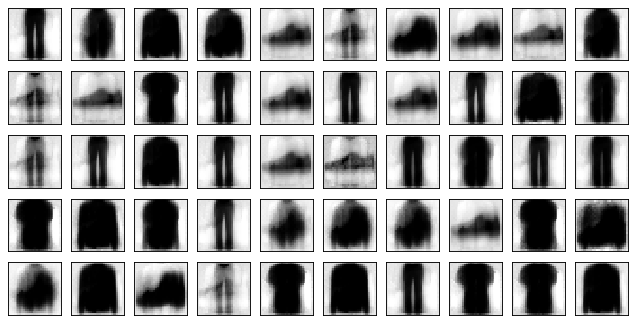

In [ ]:
result_images = {}
with torch.no_grad():
    for images_batch, _ in test_loader:
        for model_name, model in models.items():
            result_images[model_name] = models[model_name](images_batch.to(device)).cpu().view(-1, 1, 28, 28)
        break
plot(images_batch[:50], (5, 10))
for model_name in models:
    print(model_name)
    plot(result_images[model_name][:50], (5, 10))

model1


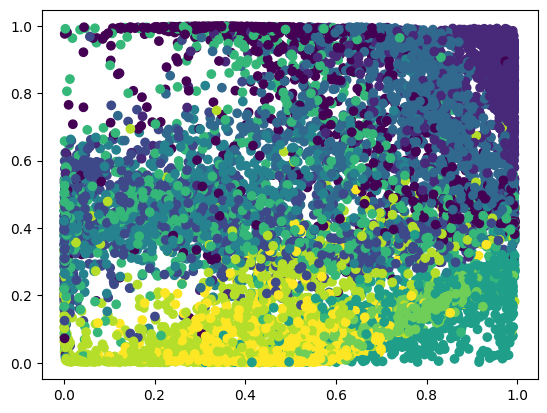

model2


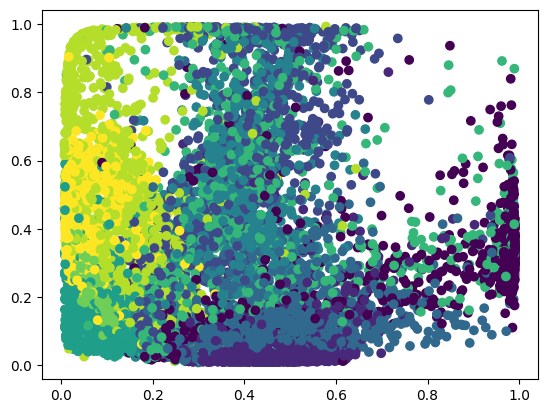

In [ ]:
label_values = []
latents =  {model_name: [] for model_name in models}
for images_batch, labels in test_loader:
    images_batch = images_batch.to(device)
    labels = labels.numpy()
    label_values.extend(labels.tolist())
    for model_name, model in models.items():
        latent = model.encode(images_batch).cpu().numpy()
        latents[model_name].extend(latent.tolist())

for model_name in models:
    label_values = np.array(label_values)
    latent = np.array(latents[model_name]).T
    print(model_name)
    plt.scatter(latent[0], latent[1], c=label_values)
    plt.show()

In [ ]:
models = {
    'model3': Net(latent_sizes=[128, 64, 32]),
    'model4': Net(latent_sizes=[64, 32]),
}
for model_name in models:
    models[model_name].to(device)
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}
device

device(type='cpu')

In [ ]:
for epoch in range(1, 10):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, test_loader, test_log)

Train Epoch: 1 [00000/60000] model3: 1.003611 model4: 1.016886
Train Epoch: 1 [09600/60000] model3: 0.638835 model4: 0.710548
Train Epoch: 1 [19200/60000] model3: 0.521692 model4: 0.578297
Train Epoch: 1 [28800/60000] model3: 0.468589 model4: 0.524680
Train Epoch: 1 [38400/60000] model3: 0.434332 model4: 0.505450
Train Epoch: 1 [48000/60000] model3: 0.374117 model4: 0.423658
Train Epoch: 1 [57600/60000] model3: 0.399847 model4: 0.436211
Train Epoch: 1 [30016/60000] model3: 0.324657 model4: 0.355266
Test set:
model3: loss: 0.3620
model4: loss: 0.3957

Train Epoch: 2 [00000/60000] model3: 0.349502 model4: 0.379064
Train Epoch: 2 [09600/60000] model3: 0.354749 model4: 0.384373
Train Epoch: 2 [19200/60000] model3: 0.352642 model4: 0.375695
Train Epoch: 2 [28800/60000] model3: 0.378000 model4: 0.403617
Train Epoch: 2 [38400/60000] model3: 0.314257 model4: 0.344428
Train Epoch: 2 [48000/60000] model3: 0.307214 model4: 0.326531
Train Epoch: 2 [57600/60000] model3: 0.335024 model4: 0.358923
Tr

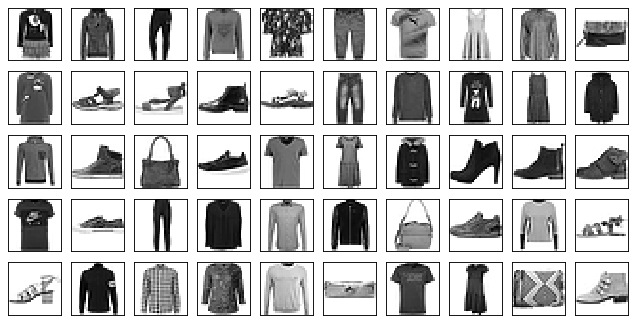

model3


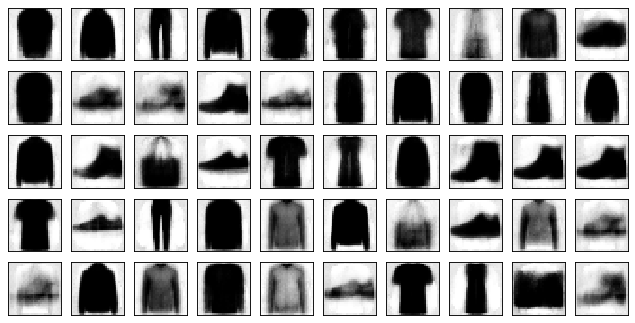

model4


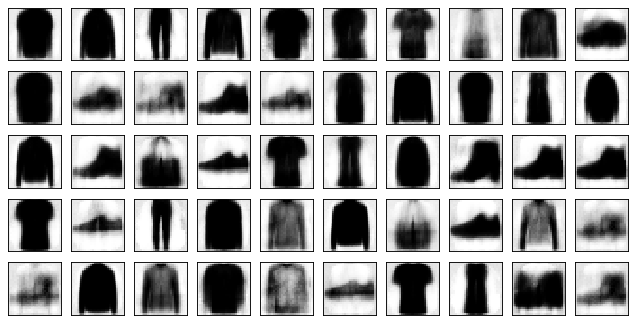

In [ ]:
result_images = {}
with torch.no_grad():
    for images_batch, _ in test_loader:
        for model_name, model in models.items():
            result_images[model_name] = models[model_name](images_batch.to(device)).cpu().view(-1, 1, 28, 28)
        break
plot(images_batch[:50], (5, 10))
for model_name in models:
    print(model_name)
    plot(result_images[model_name][:50], (5, 10))

In [ ]:
from sklearn import manifold

model3


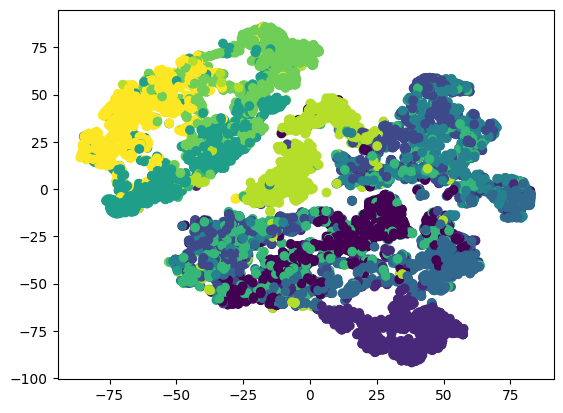

model4


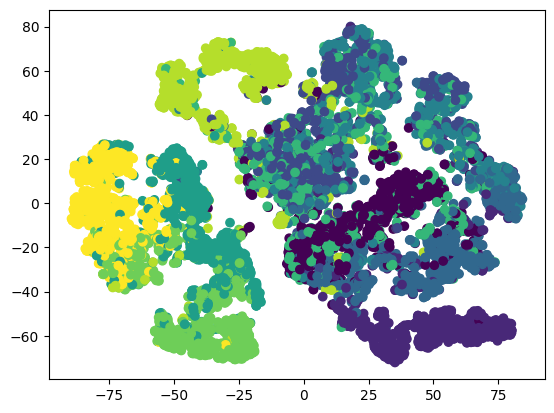

In [ ]:
label_values = []
latents =  {model_name: [] for model_name in models}
tsnes = {model_name: manifold.TSNE(n_components=2, init='pca', random_state=0) for model_name in models}
for images_batch, labels in test_loader:
    images_batch = images_batch.to(device)
    labels = labels.numpy()
    label_values.extend(labels.tolist())
    for model_name, model in models.items():
        latent = model.encode(images_batch).cpu().numpy()
        latents[model_name].extend(latent.tolist())

for model_name in models:
    label_values = np.array(label_values)
    latent = np.array(latents[model_name])
    latent_2d = tsnes[model_name].fit_transform(latent).T
    print(model_name)
    plt.scatter(latent_2d[0], latent_2d[1], c=label_values)
    plt.show()

In [ ]:
def add_gauss_noise(x, std=0.3):
    return x + std * torch.randn_like(x)

def add_mirror_image_part(x):
    x = x.clone()
    for i in range(x.shape[0]):
        img_part = np.random.randint(5)
        if img_part == 0:
            x[i, :, :14, :14] = torch.flip(x[i, :, :14, :14], dims=[2])
        elif img_part == 1:
            x[i, :, :14, 14:] = torch.flip(x[i, :, :14, 14:], dims=[2])
        elif img_part == 2:
            x[i, :, 14:, :14] = torch.flip(x[i, :, 14:, :14], dims=[2])
        elif img_part == 3:
            x[i, :, 14:, 14:] = torch.flip(x[i, :, 14:, 14:], dims=[2])
        elif img_part == 4:
            x[i, :, 7:21, 7:21] = torch.flip(x[i, :, 7:21, 7:21], dims=[2])
    return x

def add_noise(x):
    return add_mirror_image_part(add_gauss_noise(x))

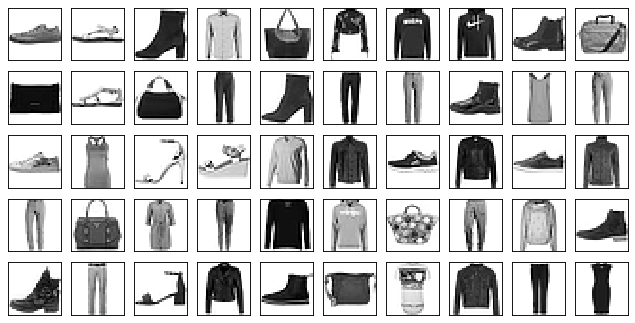

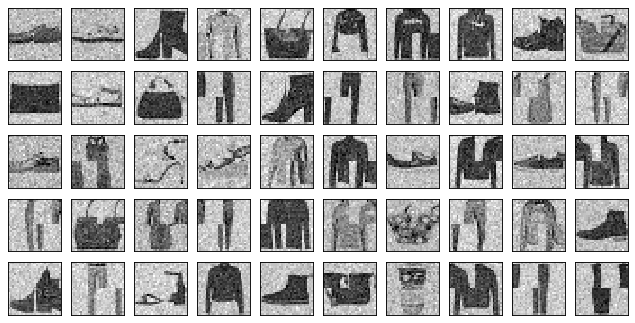

torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])


In [ ]:
data, _ = next(iter(test_loader))
noized = add_noise(data)
plot(data.data.numpy()[:50], (5, 10))
plot(noized[:50], (5, 10))
print(data.shape, noized.shape)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        noized = add_noise(data).to(device)
        data = data.to(device)
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()

        if batch_idx % 150 == 0:
            line = 'Train Epoch: {} [{:05d}/{}] '.format(
                epoch, batch_idx * len(data), train_size)
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)

    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{:05d}/{}] '.format(
            epoch, batch_idx * len(data), train_size)
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append(models[k]._loss)
        print(line + losses)

avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
line = lambda i, l: '{}: '.format(i) + avg_lambda(l)

def test(models, loader, log=None):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            noized = add_noise(data).to(device)
            data = data.to(device)
            output = {k: m(noized) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss

    for k in models:
        test_loss[k] /= (test_size * 784)
        if log is not None:
            log[k].append(test_loss[k])

    lines = '\n'.join([line(k, test_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    print(report)

In [ ]:
models = {
    'm_32_1': Net(latent_sizes=[32]),
    'm_64_32': Net(latent_sizes=[64, 32]),
    'm_128': Net(latent_sizes=[128]),
    'm_128_64': Net(latent_sizes=[128, 64]),
    'm_256': Net(latent_sizes=[256]),
    'm_512': Net(latent_sizes=[512]),
    'm_512_256': Net(latent_sizes=[512, 256]),
}
for model_name in models:
    models[model_name].to(device)
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [ ]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, test_loader, test_log)

Train Epoch: 1 [00000/60000] m_32_1: 1.081941 m_64_32: 1.044071 m_128: 1.109329 m_128_64: 1.044800 m_256: 1.077389 m_512: 1.099729 m_512_256: 1.040492
Train Epoch: 1 [09600/60000] m_32_1: 0.797176 m_64_32: 0.702248 m_128: 0.533644 m_128_64: 0.598774 m_256: 0.442488 m_512: 0.384619 m_512_256: 0.393447
Train Epoch: 1 [19200/60000] m_32_1: 0.688320 m_64_32: 0.609134 m_128: 0.457662 m_128_64: 0.497991 m_256: 0.392644 m_512: 0.334820 m_512_256: 0.366727
Train Epoch: 1 [28800/60000] m_32_1: 0.579334 m_64_32: 0.526480 m_128: 0.386267 m_128_64: 0.401331 m_256: 0.323089 m_512: 0.270410 m_512_256: 0.280002
Train Epoch: 1 [38400/60000] m_32_1: 0.507978 m_64_32: 0.468483 m_128: 0.348478 m_128_64: 0.367942 m_256: 0.288505 m_512: 0.248120 m_512_256: 0.250223
Train Epoch: 1 [48000/60000] m_32_1: 0.487619 m_64_32: 0.418960 m_128: 0.330765 m_128_64: 0.353814 m_256: 0.270917 m_512: 0.236929 m_512_256: 0.245368
Train Epoch: 1 [57600/60000] m_32_1: 0.458471 m_64_32: 0.403486 m_128: 0.324001 m_128_64: 0.35

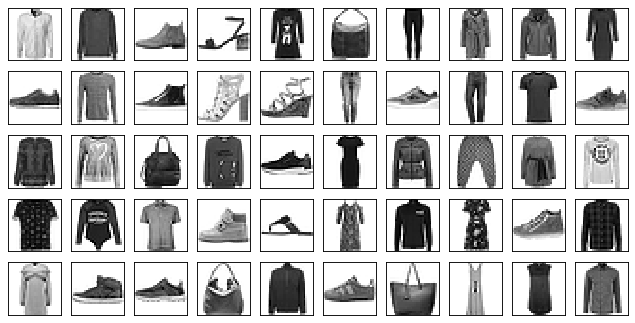

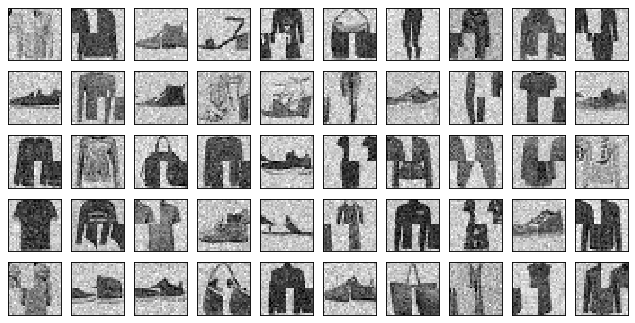

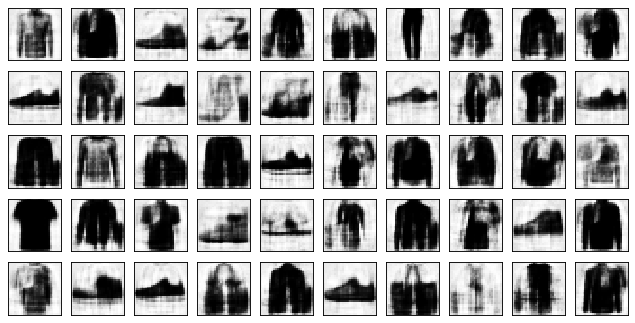

In [ ]:
data, _ = next(iter(test_loader))
noized = add_noise(data)
output = models['m_128'](noized[:50].to(device)).cpu()
to_plot = output.view(-1, 1, 28, 28).data.numpy()
plot(data.data.numpy()[:50], (5, 10))
plot(noized[:50], (5, 10))
plot(to_plot, (5, 10))

m_128


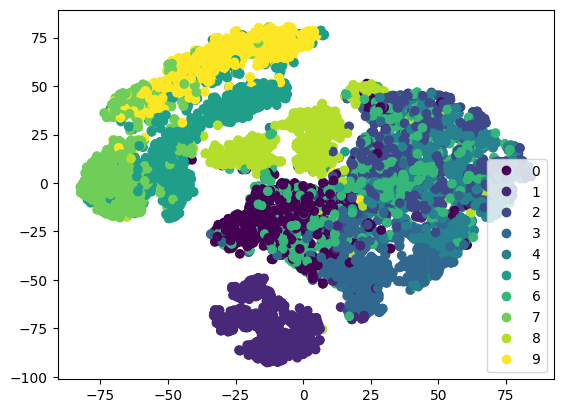

In [ ]:
model_name = 'm_128'
model = models[model_name]
label_values = []
latents =  []
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
for images_batch, labels in test_loader:
    images_batch = images_batch.to(device)
    labels = labels.numpy()
    label_values.extend(labels.tolist())
    latent = model.encode(images_batch).cpu().numpy()
    latents.extend(latent.tolist())

label_values = np.array(label_values)
latent = np.array(latents)
latent_2d = tsne.fit_transform(latent).T
print(model_name)

fig, ax = plt.subplots()
scatter = ax.scatter(latent_2d[0], latent_2d[1], c=label_values)
ax.legend(*scatter.legend_elements())
plt.show()